# Preprocess Lab

In [49]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from bcd.utils.image import convert_uint8


In [50]:
img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"


## Plotting Functions

In [51]:
def suppress_ticks(axes) -> None:
    for ax in axes:
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])

In [55]:
def plot_images(images: list, title: str):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12,4))
    for i, image in enumerate(images):
        _ = axes[i].imshow(image, cmap='gray', aspect='auto')
    suppress_ticks(axes)
    _ = plt.tight_layout(rect=(0,0,1,0.95))
    _ = fig.suptitle(title)

In [53]:
img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

## Original Images

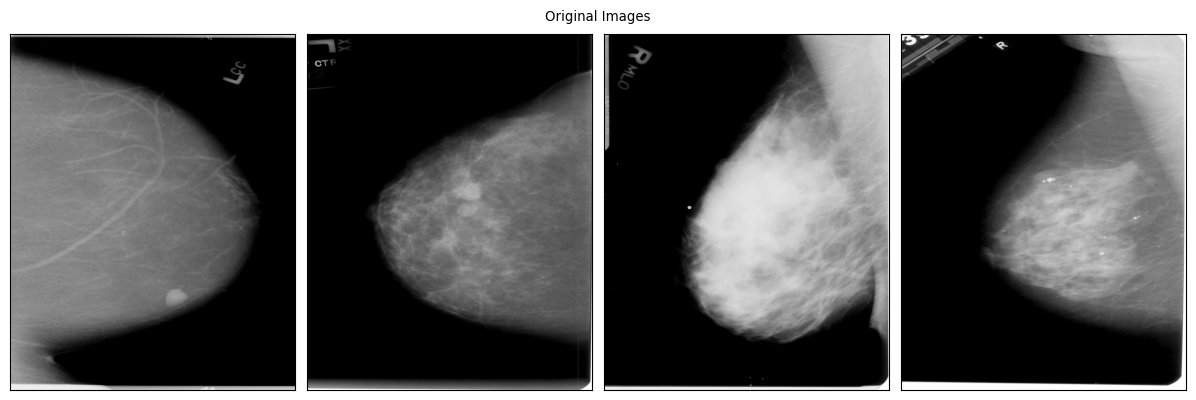

In [56]:
images = [img1,img2,img3,img4]
title = "Original Images"
plot_images(images, title)

## Denoising

In [ ]:
img1_dn = cv2.medianBlur(img1, 3)
img2_dn = cv2.medianBlur(img2, 3)
img3_dn = cv2.medianBlur(img3, 3)
img4_dn = cv2.medianBlur(img4, 3)

In [ ]:
images = [img1_dn,img2_dn,img3_dn,img4_dn]
title = "Denoised Images"
plot_images(images, title)

## Artifact Removal

### OTSU Threshold

In [ ]:
_, img1_otsu = cv2.threshold(img1_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img2_otsu = cv2.threshold(img2_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img3_otsu = cv2.threshold(img3_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img4_otsu = cv2.threshold(img4_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

### Find Contours

In [ ]:
img1_contours = cv2.findContours(img1_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img2_contours = cv2.findContours(img2_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img3_contours = cv2.findContours(img3_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img4_contours = cv2.findContours(img4_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

### Compute Contour Areas

In [ ]:
img1_contour_areas = [cv2.contourArea(cont) for cont in img1_contours]
img2_contour_areas = [cv2.contourArea(cont) for cont in img2_contours]
img3_contour_areas = [cv2.contourArea(cont) for cont in img3_contours]
img4_contour_areas = [cv2.contourArea(cont) for cont in img4_contours]

img1_idx = np.argmax(img1_contour_areas)
img2_idx = np.argmax(img2_contour_areas)
img3_idx = np.argmax(img3_contour_areas)
img4_idx = np.argmax(img4_contour_areas)

### Draw Contours

In [ ]:
img1_mask = cv2.drawContours(np.zeros_like(img1_otsu), img1_contours, img1_idx, 255, -1)
img2_mask = cv2.drawContours(np.zeros_like(img2_otsu), img2_contours, img2_idx, 255, -1)
img3_mask = cv2.drawContours(np.zeros_like(img3_otsu), img3_contours, img3_idx, 255, -1)
img4_mask = cv2.drawContours(np.zeros_like(img4_otsu), img4_contours, img4_idx, 255, -1)

### Segment the Breast

In [ ]:
img1_seg = cv2.bitwise_and(img1, img1, mask=img1_mask)
img2_seg = cv2.bitwise_and(img2, img2, mask=img2_mask)
img3_seg = cv2.bitwise_and(img3, img3, mask=img3_mask)
img4_seg = cv2.bitwise_and(img4, img4, mask=img4_mask)

### Artifacts Removed

## Enhance Image

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img1_enhanced = clahe.apply(img1_seg)
img2_enhanced = clahe.apply(img2_seg)
img3_enhanced = clahe.apply(img3_seg)
img4_enhanced = clahe.apply(img4_seg)

## Crop Image

In [ ]:
def crop_image(img, contour):
    x,y,w,h = cv2.boundingRect(contour)
    return img[y:y+h, x:x+w]

In [ ]:
img1_crop = crop_image(img1_enhanced, img1_contours[img1_idx])
img2_crop = crop_image(img2_enhanced, img2_contours[img2_idx])
img3_crop = crop_image(img3_enhanced, img3_contours[img3_idx])
img4_crop = crop_image(img4_enhanced, img4_contours[img4_idx])

### Segmented Images

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
_ = axes[0].imshow(img1_seg, cmap='gray', aspect='auto')
_ = axes[1].imshow(img2_seg, cmap='gray', aspect='auto')
_ = axes[2].imshow(img3_seg, cmap='gray', aspect='auto')
_ = axes[3].imshow(img4_seg, cmap='gray', aspect='auto')
suppress_ticks(axes)
fig.suptitle("Segmented Images")

### Enhanced Images

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
_ = axes[0].imshow(img1_enhanced, cmap='gray', aspect='auto')
_ = axes[1].imshow(img2_enhanced, cmap='gray', aspect='auto')
_ = axes[2].imshow(img3_enhanced, cmap='gray', aspect='auto')
_ = axes[3].imshow(img4_enhanced, cmap='gray', aspect='auto')
suppress_ticks(axes)
fig.suptitle("Enhanced Images")

### Cropped Images

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
_ = axes[0].imshow(img1_crop, cmap='gray', aspect='auto')
_ = axes[1].imshow(img2_crop, cmap='gray', aspect='auto')
_ = axes[2].imshow(img3_crop, cmap='gray', aspect='auto')
_ = axes[3].imshow(img4_crop, cmap='gray', aspect='auto')
suppress_ticks(axes)
fig.suptitle("Cropped Images")